**PREPARED BY IBRAHIM ABU SAIID**

---

# Analyzing Socio-Demographic Factors Influencing High School Performance #


---

This notebook analyzes high school students' performance and demographics using the **High School Student Performance & Demographics** dataset. By leveraging PySpark, it processes and visualizes large-scale data efficiently, focusing on key student attributes like grades, parental involvement, and study time.

---


**Content:**
1. **Importing Libraries**
2. **Loading the Data**
3. **Data Preprocessing**
5. **Analysis & Visualization**



---


**DATA SCIENCE QUESTIONS:**

Descriptive analysis:
1. What is the distribution of final grades between males and females in Mathematics and Portuguese language courses?

2. How does the weekly study time correlate with final grades in Mathematics and Portuguese language courses?

Exploratory analysis:
3. Is there a notable difference in final grades between urban and rural students?

4. Is there a significant difference in final grades based on parental education levels?

5. Is there a correlation between student absences using factors like weekend alcohol consumption, weekday alcohol consumption, and social activities?

Inferential Analysis:
6. Can we infer the combined impact of study time, health status, and absences on students' final grades?

Diagnostic Analysis:
7. Can we diagnose the impact of family support and participation in extra paid classes on students' final grades?

8. Can we diagnose how the combination of participating in extra-curricular activities, health status, and study time influences students' final grades?

Causal analysis:
9. Can the number of past class failures be attributed to variables such as romantic relationships, health status, and study time?

10. Are there any notable clusters or patterns in student performance based on a combination of multiple features like guardian type, reasons for school choice, and internet access at home?

11. Is there a causal relationship between internet access, travel time, parental occupations, and students' study time?

Prescriptive Analysis:
12. What study time intervals should be prescribed for optimal academic performance based on varying family sizes and guardian types?



---


**1. Importing Libraries**

In [59]:
# Importing necessary libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

!apt-get install openjdk-8-jdk-headless -qq> /dev/null

!wget -q https://dlcdn.apache.org/spark/spark-3.3.4/spark-3.3.4-bin-hadoop3.tgz

!tar xf spark-3.3.4-bin-hadoop3.tgz

import os
os.environ["JAVA_HOME"]= "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"]= "/content/spark-3.3.4-bin-hadoop3"

!pip install -q findspark
import findspark
findspark.init()


from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('High School Student Performance & Demographics').getOrCreate()

# Import specific functions and modules from PySpark for data manipulation and analysis.
from pyspark.sql.functions import col, when, trim, avg, count, asc, desc, sum , isnull, expr, mean, udf, percentile_approx, lit
from pyspark.sql import functions as F
from pyspark.sql.functions import col
from pyspark.sql.types import StringType

**2. Loading the Data**

In [60]:
student_math_spark = spark.read.csv('student_math_clean.csv', header=True, inferSchema=True)
student_portuguese_spark = spark.read.csv('student_portuguese_clean.csv', header=True, inferSchema=True)

In [61]:
student_math_spark.show()
student_portuguese_spark.show()

+----------+------+---+---+------------+--------------------+---------------+--------------------+--------------------+----------+----------+--------------------+--------+-----------------+-------------+--------------+--------------+--------------+------------------+----------+--------------+---------+---------------+---------------------+-------------------+---------+------+---------------+---------------+------+--------+-------+-------+-----------+
|student_id|school|sex|age|address_type|         family_size|  parent_status|    mother_education|    father_education|mother_job|father_job|school_choice_reason|guardian|      travel_time|   study_time|class_failures|school_support|family_support|extra_paid_classes|activities|nursery_school|higher_ed|internet_access|romantic_relationship|family_relationship|free_time|social|weekday_alcohol|weekend_alcohol|health|absences|grade_1|grade_2|final_grade|
+----------+------+---+---+------------+--------------------+---------------+-------------

In [62]:
student_math_spark.summary().show()
student_portuguese_spark.summary().show()

+-------+------------------+------+----+------------------+------------+--------------------+---------------+-------------------+-------------------+----------+----------+--------------------+--------+-------------+------------+------------------+--------------+--------------+------------------+----------+--------------+---------+---------------+---------------------+-------------------+------------------+------------------+------------------+------------------+------------------+-----------------+------------------+------------------+------------------+
|summary|        student_id|school| sex|               age|address_type|         family_size|  parent_status|   mother_education|   father_education|mother_job|father_job|school_choice_reason|guardian|  travel_time|  study_time|    class_failures|school_support|family_support|extra_paid_classes|activities|nursery_school|higher_ed|internet_access|romantic_relationship|family_relationship|         free_time|            social|   weekday_

**3. Data Preprocessing**

-   Checking for Null Values

In [63]:
# Check for null values in student_math_spark
null_values_math = student_math_spark.select([count(when(isnull(c), c)).alias(c) for c in student_math_spark.columns])

# Check for null values in student_portuguese_spark
null_values_portuguese = student_portuguese_spark.select([count(when(isnull(c), c)).alias(c) for c in student_portuguese_spark.columns])

# Printing null values
print("No Null Values")
null_values_math.show()
null_values_portuguese.show()

No Null Values
+----------+------+---+---+------------+-----------+-------------+----------------+----------------+----------+----------+--------------------+--------+-----------+----------+--------------+--------------+--------------+------------------+----------+--------------+---------+---------------+---------------------+-------------------+---------+------+---------------+---------------+------+--------+-------+-------+-----------+
|student_id|school|sex|age|address_type|family_size|parent_status|mother_education|father_education|mother_job|father_job|school_choice_reason|guardian|travel_time|study_time|class_failures|school_support|family_support|extra_paid_classes|activities|nursery_school|higher_ed|internet_access|romantic_relationship|family_relationship|free_time|social|weekday_alcohol|weekend_alcohol|health|absences|grade_1|grade_2|final_grade|
+----------+------+---+---+------------+-----------+-------------+----------------+----------------+----------+----------+---------

- Checking for Duplicate Values

In [64]:
# Check for duplicate values in student_math_spark
duplicates_math = student_math_spark.groupBy(student_math_spark.columns).count().filter(col("count") > 1).count()

# Check for duplicate values in student_portuguese_spark
duplicates_portuguese = student_portuguese_spark.groupBy(student_portuguese_spark.columns).count().filter(col("count") > 1).count()

# Print results
print("Duplicate Values in the Math Students Dataset:", duplicates_math)
print("Duplicate Values in the portuguese Dataset:", duplicates_portuguese)

Duplicate Values in the Math Students Dataset: 0
Duplicate Values in the portuguese Dataset: 0


- Combining Datasets

In [65]:
# Add a new column to each dataframe to identify the source (Math or Portuguese)
student_math = student_math_spark.withColumn("source", lit("Math"))
student_portuguese = student_portuguese_spark.withColumn("source", lit("Portuguese"))

# Union the datasets
combined_data = student_math.union(student_portuguese)

In [66]:
combined_data.show()
combined_data.summary().show()

+----------+------+---+---+------------+--------------------+---------------+--------------------+--------------------+----------+----------+--------------------+--------+-----------------+-------------+--------------+--------------+--------------+------------------+----------+--------------+---------+---------------+---------------------+-------------------+---------+------+---------------+---------------+------+--------+-------+-------+-----------+------+
|student_id|school|sex|age|address_type|         family_size|  parent_status|    mother_education|    father_education|mother_job|father_job|school_choice_reason|guardian|      travel_time|   study_time|class_failures|school_support|family_support|extra_paid_classes|activities|nursery_school|higher_ed|internet_access|romantic_relationship|family_relationship|free_time|social|weekday_alcohol|weekend_alcohol|health|absences|grade_1|grade_2|final_grade|source|
+----------+------+---+---+------------+--------------------+---------------

**What is the distribution of final grades between males and females in Mathematics and Portuguese language courses?**

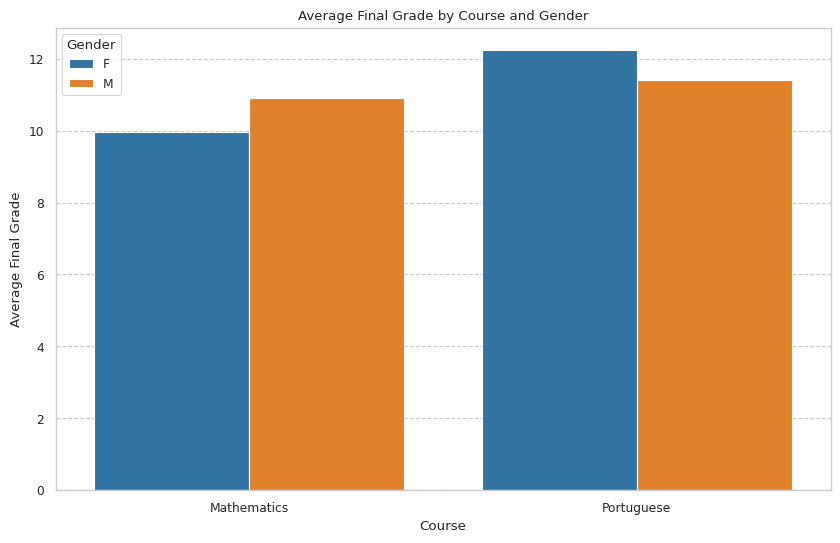

In [67]:
data1 = student_math_spark
data2 = student_portuguese_spark

# Calculate average final grade for each course and gender
avg_final_grade_math = data1.select('sex', 'final_grade') \
                            .groupBy('sex') \
                            .agg(F.mean('final_grade').alias('average_final_grade')) \
                            .withColumn('course', F.lit('Mathematics'))

avg_final_grade_portuguese = data2.select('sex', 'final_grade') \
                                  .groupBy('sex') \
                                  .agg(F.mean('final_grade').alias('average_final_grade')) \
                                  .withColumn('course', F.lit('Portuguese'))

# Concatenate the DataFrames
avg_final_grade = avg_final_grade_math.union(avg_final_grade_portuguese)

# Convert Spark DataFrame to Pandas DataFrame for visualization
avg_final_grade_pandas = avg_final_grade.toPandas()

# Set the context to adjust the font scale of the legend
sns.set_context("paper", font_scale=1)

# Set the style to enable the grid and make it dotted
sns.set_style("whitegrid", {'grid.linestyle': '--'})
# Plot the bar chart using seaborn
plt.figure(figsize=(10, 6))
sns.barplot(data=avg_final_grade_pandas, x='course', y='average_final_grade', hue='sex')
plt.xlabel('Course')
plt.ylabel('Average Final Grade')
plt.title('Average Final Grade by Course and Gender')
plt.legend(title='Gender')
plt.show()

**How does the weekly study time correlate with final grades in Mathematics and Portuguese language courses?**

In [68]:
# Find unique values of 'study_time' in data1
data1.select('study_time').distinct().show()

# Find unique values of 'study_time' in data2
data2.select('study_time').distinct().show()

+-------------+
|   study_time|
+-------------+
|5 to 10 hours|
|    >10 hours|
|     <2 hours|
| 2 to 5 hours|
+-------------+

+-------------+
|   study_time|
+-------------+
|5 to 10 hours|
|    >10 hours|
|     <2 hours|
| 2 to 5 hours|
+-------------+



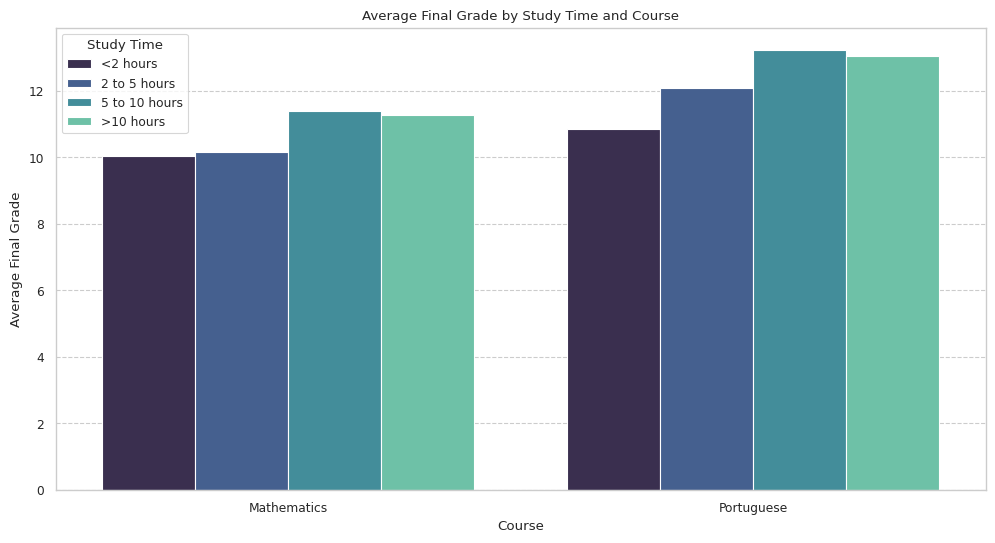

In [69]:
# Calculate average final grade for each course and studytime
avg_final_grade_math_2 = data1.select('study_time', 'final_grade') \
                            .groupBy('study_time') \
                            .agg(F.mean('final_grade').alias('average_final_grade')) \
                            .withColumn('course', F.lit('Mathematics'))

avg_final_grade_portuguese_2 = data2.select('study_time', 'final_grade') \
                                  .groupBy('study_time') \
                                  .agg(F.mean('final_grade').alias('average_final_grade')) \
                                  .withColumn('course', F.lit('Portuguese'))

# Concatenate the DataFrames
avg_final_grade_2 = avg_final_grade_math_2.union(avg_final_grade_portuguese_2)

# Convert Spark DataFrame to Pandas DataFrame for visualization
avg_final_grade_pandas_2 = avg_final_grade_2.toPandas()

# Define the desired order of study time categories
study_time_order = ["<2 hours", "2 to 5 hours", "5 to 10 hours", ">10 hours"]

# Set the context to adjust the font scale of the legend
sns.set_context("paper", font_scale=1)

# Set the style to enable the grid and make it dotted
sns.set_style("whitegrid", {'grid.linestyle': '--'})

# Plot the bar chart using seaborn with specified order
plt.figure(figsize=(12, 6))
sns.barplot(data=avg_final_grade_pandas_2, x='course', y='average_final_grade', hue='study_time', palette='mako', hue_order=study_time_order)
plt.xlabel('Course')
plt.ylabel('Average Final Grade')
plt.title('Average Final Grade by Study Time and Course')
plt.legend(title='Study Time', loc='upper left')
plt.show()

**Is there a notable difference in final grades between urban and rural students?**

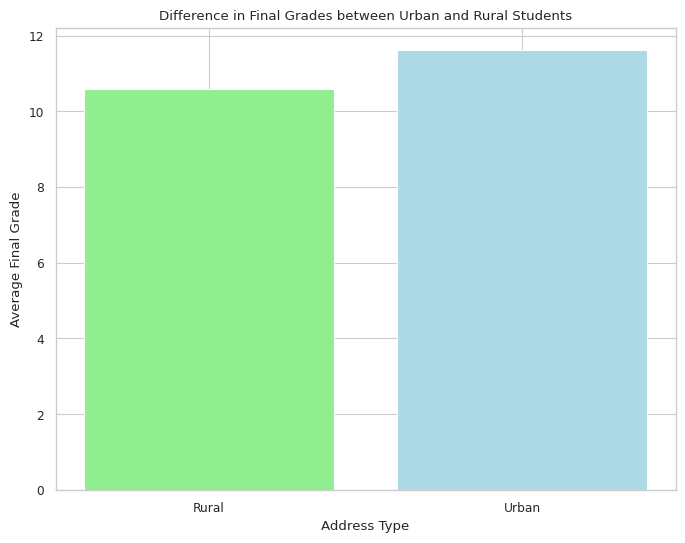

In [70]:
# Set distinct colors for urban and rural
colors = ['lightgreen', 'lightblue']
sns.set_style("whitegrid")
# Address Type vs Final Grade
address_type_result = combined_data.groupBy('address_type').agg({'final_grade': 'mean'}).toPandas()
address_type_result = address_type_result.sort_values(by='address_type')

plt.figure(figsize=(8, 6))
plt.bar(address_type_result['address_type'], address_type_result['avg(final_grade)'], color=colors)
plt.title("Difference in Final Grades between Urban and Rural Students")
plt.xlabel("Address Type")
plt.ylabel("Average Final Grade")
#plt.savefig('3.png')
plt.show()

**Is there a significant difference in final grades based on parental education levels?**

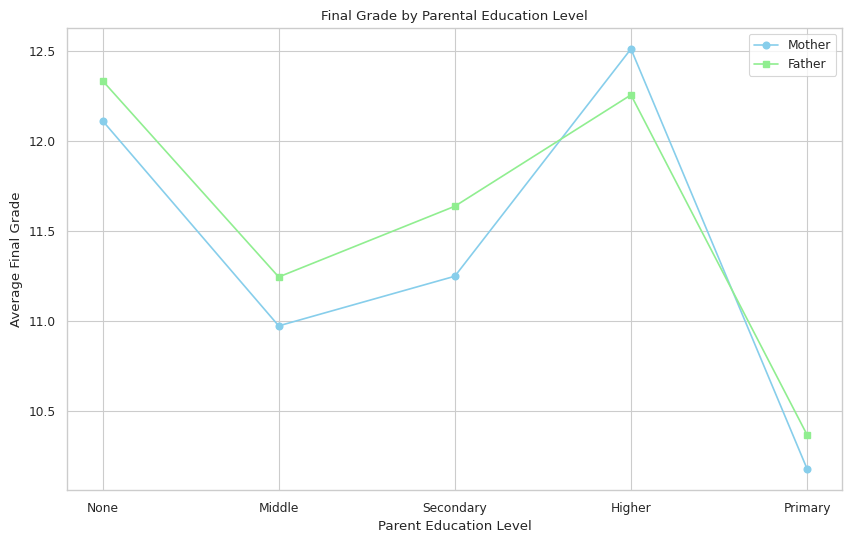

In [71]:
# Define a mapping function to standardize education levels
def map_education(level):
    education_mapping = {
        "none": "None",
        "primary education (4th grade)": "Primary",
        "5th to 9th grade": "Middle",
        "secondary education": "Secondary",
        "higher education": "Higher"
    }
    return education_mapping.get(level, "Unknown")

# Register the mapping function as a User-Defined Function (UDF) for Spark
map_education_udf = udf(map_education, StringType())

# Apply the mapping to the PySpark DataFrames
columns_to_transform = ['mother_education', 'father_education']
for column in columns_to_transform:
    student_math_spark = student_math_spark.withColumn(column, map_education_udf(col(column)))
    student_portuguese_spark = student_portuguese_spark.withColumn(column, map_education_udf(col(column)))

# Combine the datasets
combined_data_4 = student_math_spark.select('mother_education', 'father_education', 'final_grade') \
    .unionByName(student_portuguese_spark.select('mother_education', 'father_education', 'final_grade'))

# Group by parental education levels and calculate the average final grade
grouped_by_mother_education = combined_data_4.groupBy('mother_education').avg('final_grade').withColumnRenamed('avg(final_grade)', 'avg_final_grade')
grouped_by_father_education = combined_data_4.groupBy('father_education').avg('final_grade').withColumnRenamed('avg(final_grade)', 'avg_final_grade')

# Convert to Pandas DataFrame for plotting
pdf_mother = grouped_by_mother_education.toPandas()
pdf_father = grouped_by_father_education.toPandas()

# Plotting the line graph
plt.figure(figsize=(10, 6))
plt.plot(pdf_mother['mother_education'], pdf_mother['avg_final_grade'], label='Mother', marker='o', color='skyblue')
plt.plot(pdf_father['father_education'], pdf_father['avg_final_grade'], label='Father', marker='s', color='lightgreen')

plt.title('Final Grade by Parental Education Level')
plt.xlabel('Parent Education Level')
plt.ylabel('Average Final Grade')
plt.legend()
plt.grid(True)
plt.show()

**Is there a correlation between student absences using factors like weekend alcohol consumption, weekday alcohol consumption, and social activities?**

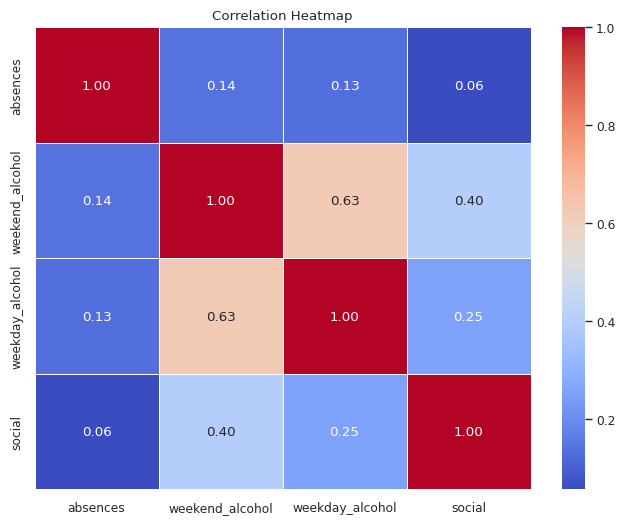

In [72]:
# Combine the necessary columns
combined_data_analysis = student_math_spark.select('absences', 'weekend_alcohol', 'weekday_alcohol', 'social') \
    .unionByName(student_portuguese_spark.select('absences', 'weekend_alcohol', 'weekday_alcohol', 'social'))

# Since PySpark doesn't directly compute a correlation matrix, we calculate pairwise correlations and manually assemble them into a pandas DataFrame for the heatmap
# Define the columns for which to compute correlations
columns = combined_data_analysis.columns
n_columns = len(columns)

# Initialize an empty DataFrame to store correlation values
correlation_matrix_pd = pd.DataFrame(index=columns, columns=columns)

# Calculate pairwise correlations and fill in the DataFrame
for i in range(n_columns):
    for j in range(i, n_columns):
        col1 = columns[i]
        col2 = columns[j]
        corr = combined_data_analysis.stat.corr(col1, col2)
        correlation_matrix_pd.loc[col1, col2] = corr
        correlation_matrix_pd.loc[col2, col1] = corr

# Convert the correlation values to numeric types for plotting
correlation_matrix_pd = correlation_matrix_pd.astype(float)

# Creating a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix_pd, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Heatmap')
plt.show()

**Can we infer the combined impact of study time, health status, and absences on students' final grades?**

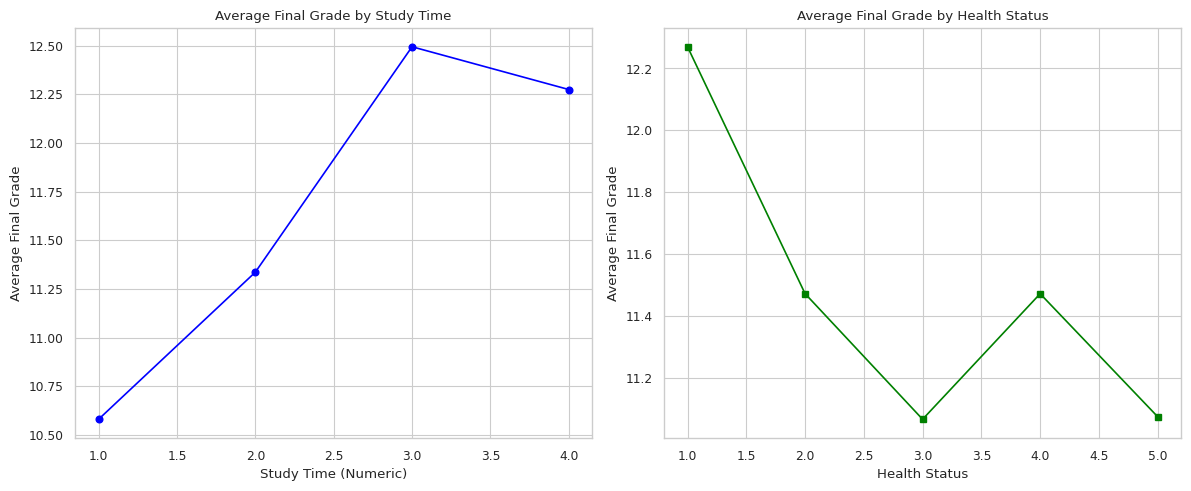

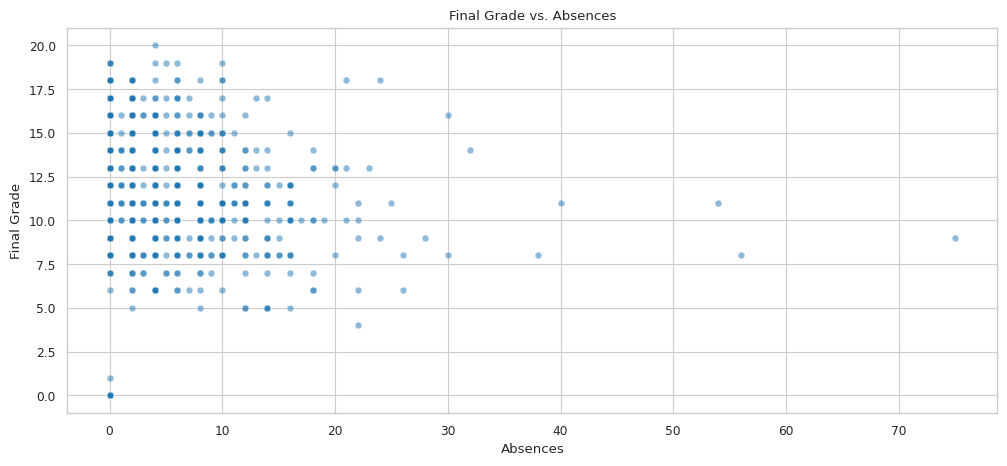

In [73]:
# Combining the necessary columns from both datasets

student_math_pd = student_math.toPandas()
student_portuguese_pd = student_portuguese.toPandas()

study_time_health_absences = pd.concat([
    student_math_pd[['study_time', 'health', 'absences', 'final_grade']],
    student_portuguese_pd[['study_time', 'health', 'absences', 'final_grade']]
])

# Mapping 'study_time' from categorical to numeric for easier analysis
study_time_mapping = {
    "<2 hours": 1,
    "2 to 5 hours": 2,
    "5 to 10 hours": 3,
    ">10 hours": 4
}
study_time_health_absences['study_time_numeric'] = study_time_health_absences['study_time'].map(study_time_mapping)

# Average Final Grade by Study Time
average_by_study_time = study_time_health_absences.groupby('study_time_numeric')['final_grade'].mean()
# Average Final Grade by Health Status
average_by_health = study_time_health_absences.groupby('health')['final_grade'].mean()

# Plotting the graphs
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

ax[0].plot(average_by_study_time.index, average_by_study_time.values, marker='o', linestyle='-', color='blue')
ax[0].set_title('Average Final Grade by Study Time')
ax[0].set_xlabel('Study Time (Numeric)')
ax[0].set_ylabel('Average Final Grade')

ax[1].plot(average_by_health.index, average_by_health.values, marker='s', linestyle='-', color='green')
ax[1].set_title('Average Final Grade by Health Status')
ax[1].set_xlabel('Health Status')
ax[1].set_ylabel('Average Final Grade')

plt.tight_layout()
plt.show()

# Final Grade vs. Absences Scatter Plot
plt.figure(figsize=(12, 5))
sns.scatterplot(data=study_time_health_absences, x='absences', y='final_grade', alpha=0.5)
plt.title('Final Grade vs. Absences')
plt.xlabel('Absences')
plt.ylabel('Final Grade')
plt.show()

**Can we diagnose the impact of family support and participation in extra paid classes on students' final grades?**

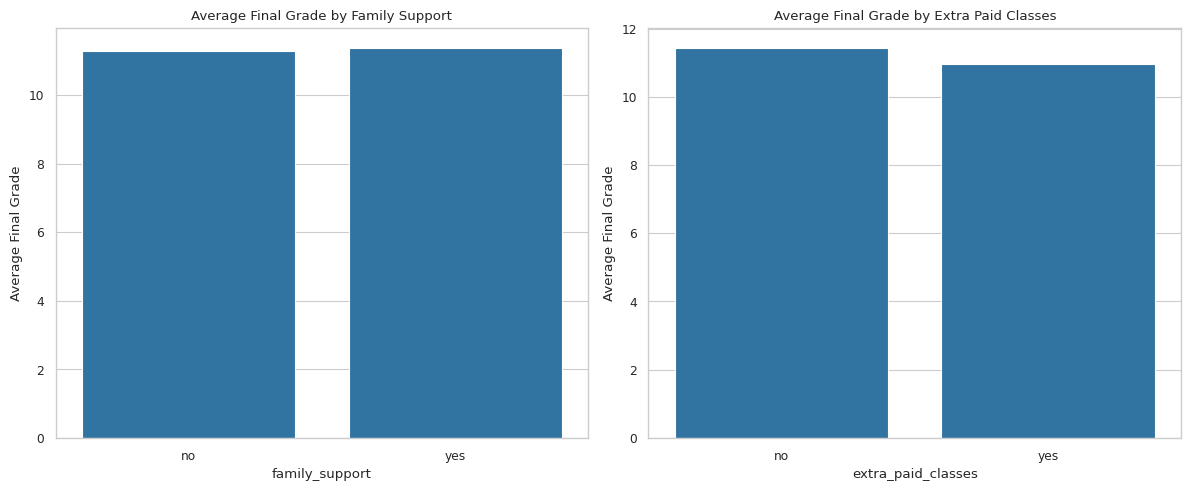

In [74]:
# Combine the datasets
combined_data_7 = student_math_spark.select('family_support', 'extra_paid_classes', 'final_grade') \
    .unionByName(student_portuguese_spark.select('family_support', 'extra_paid_classes', 'final_grade'))

# Calculating the average final grade for each category in family support and extra paid classes
avg_final_grade_family_support = combined_data_7.groupBy('family_support').avg('final_grade').toPandas()
avg_final_grade_extra_classes = combined_data_7.groupBy('extra_paid_classes').avg('final_grade').toPandas()

# Visualizing the impact using bar charts
plt.figure(figsize=(12, 5))

# Bar Chart for Impact of Family Support on Final Grades
plt.subplot(1, 2, 1)
sns.barplot(x='family_support', y='avg(final_grade)', data=avg_final_grade_family_support)
plt.title('Average Final Grade by Family Support')
plt.ylabel('Average Final Grade')

# Bar Chart for Impact of Extra Paid Classes on Final Grades
plt.subplot(1, 2, 2)
sns.barplot(x='extra_paid_classes', y='avg(final_grade)', data=avg_final_grade_extra_classes)
plt.title('Average Final Grade by Extra Paid Classes')
plt.ylabel('Average Final Grade')

plt.tight_layout()
plt.show()

**Can we diagnose how the combination of participating in extra-curricular activities, health status, and study time influences students' final grades?**

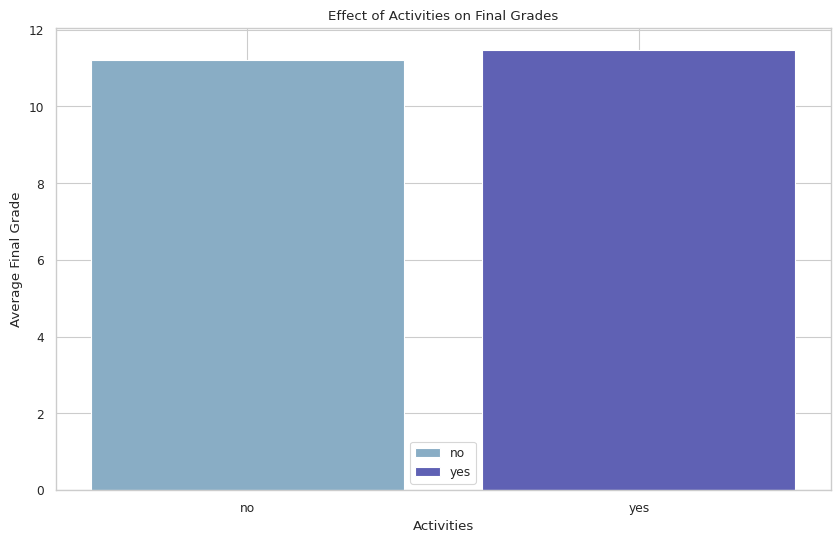

In [75]:
# Activities vs Final Grade

q8_columns = ["activities", "health", "study_time", "final_grade"]
q8_data = combined_data.select(q8_columns)
sns.set_style("whitegrid")
activities_result = q8_data.groupBy('activities').agg({'final_grade': 'mean'}).toPandas()
sns.set_palette("twilight")
plt.figure(figsize=(10, 6))
for i, activity in enumerate(activities_result['activities']):
    plt.bar(activity, activities_result.loc[i, 'avg(final_grade)'], label=activity)

plt.title("Effect of Activities on Final Grades")
plt.xlabel("Activities")
plt.ylabel("Average Final Grade")
plt.legend()
#plt.savefig('8-1.png')
plt.show()

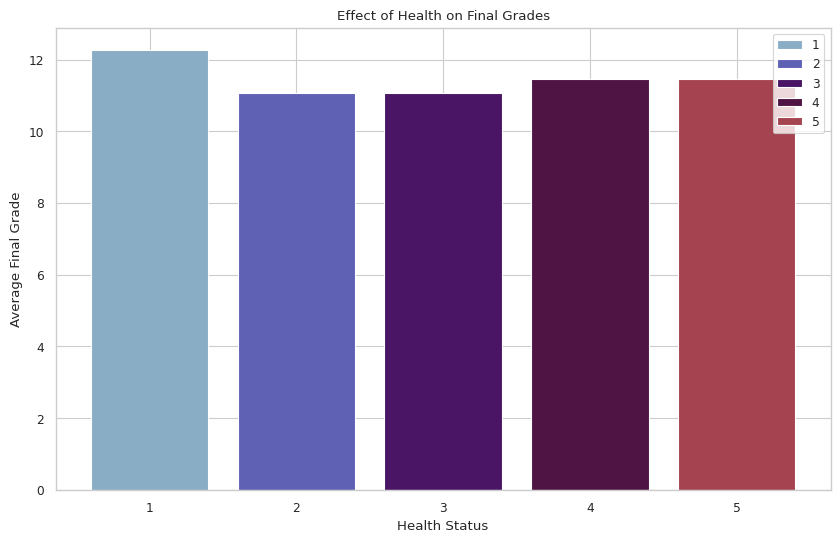

In [76]:
# Health vs Final Grade
health_result = q8_data.groupBy('health').agg({'final_grade': 'mean'}).toPandas()
health_result = health_result.sort_values(by='health')
sns.set_style("whitegrid")
plt.figure(figsize=(10, 6))
for i, health_status in enumerate(health_result['health']):
    plt.bar(health_status, health_result.loc[i, 'avg(final_grade)'], label=health_status)

plt.title("Effect of Health on Final Grades")
plt.xlabel("Health Status")
plt.ylabel("Average Final Grade")
plt.legend()
#plt.savefig('8-2.png')
plt.show()

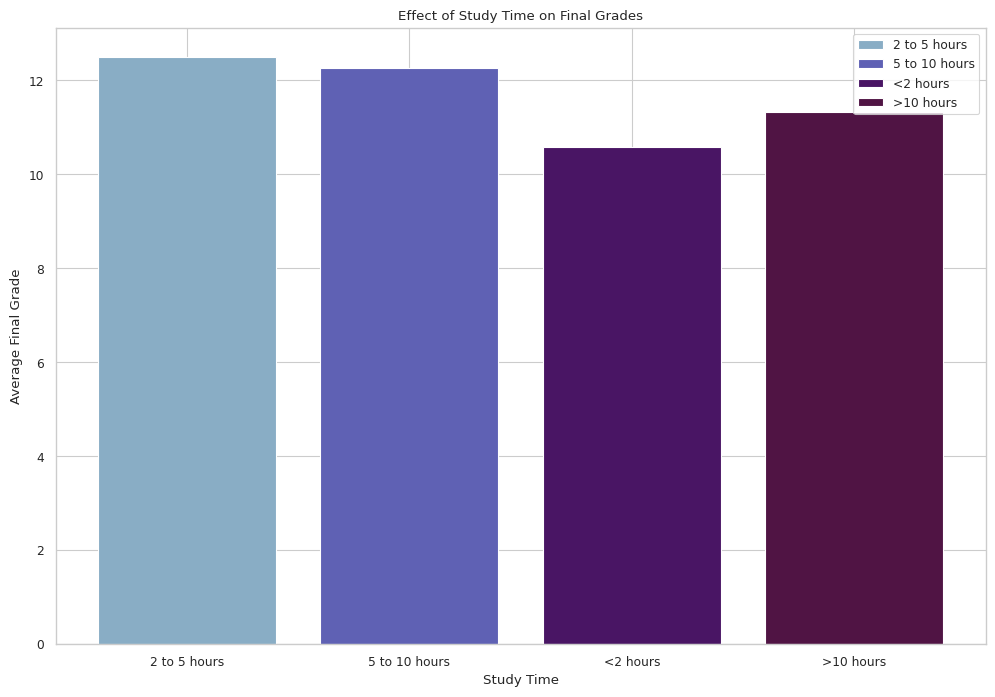

In [77]:
# Study Time vs Final Grade
study_time_result = q8_data.groupBy('study_time').agg({'final_grade': 'mean'}).toPandas()
study_time_result = study_time_result.sort_values(by='study_time')
sns.set_style("whitegrid")
plt.figure(figsize=(12, 8))
for i, study_time_level in enumerate(study_time_result['study_time']):
    plt.bar(study_time_level, study_time_result.loc[i, 'avg(final_grade)'], label=study_time_level)

plt.title("Effect of Study Time on Final Grades")
plt.xlabel("Study Time")
plt.ylabel("Average Final Grade")
plt.legend()
#plt.savefig('8-3.png')
plt.show()

**Can the number of past class failures be attributed to variables such as romantic relationships, health status, and study time?**

In [78]:
# Find unique values in data1
data1.select('class_failures').distinct().show()
data1.select('romantic_relationship').distinct().show()
data1.select('health').distinct().show()
data1.select('study_time').distinct().show()

+--------------+
|class_failures|
+--------------+
|             1|
|             3|
|             2|
|             0|
+--------------+

+---------------------+
|romantic_relationship|
+---------------------+
|                   no|
|                  yes|
+---------------------+

+------+
|health|
+------+
|     1|
|     3|
|     5|
|     4|
|     2|
+------+

+-------------+
|   study_time|
+-------------+
|5 to 10 hours|
|    >10 hours|
|     <2 hours|
| 2 to 5 hours|
+-------------+



In [79]:
# Select relevant variables from data1
union_data_2 = data1.union(data2)
union_data_2 = union_data_2.select('class_failures', 'romantic_relationship', 'health', 'study_time')
union_data_2.show()

+--------------+---------------------+------+-------------+
|class_failures|romantic_relationship|health|   study_time|
+--------------+---------------------+------+-------------+
|             0|                   no|     3| 2 to 5 hours|
|             0|                   no|     3| 2 to 5 hours|
|             3|                   no|     3| 2 to 5 hours|
|             0|                  yes|     5|5 to 10 hours|
|             0|                   no|     5| 2 to 5 hours|
|             0|                   no|     5| 2 to 5 hours|
|             0|                   no|     3| 2 to 5 hours|
|             0|                   no|     1| 2 to 5 hours|
|             0|                   no|     1| 2 to 5 hours|
|             0|                   no|     5| 2 to 5 hours|
|             0|                   no|     2| 2 to 5 hours|
|             0|                   no|     4|5 to 10 hours|
|             0|                   no|     5|     <2 hours|
|             0|                   no|  

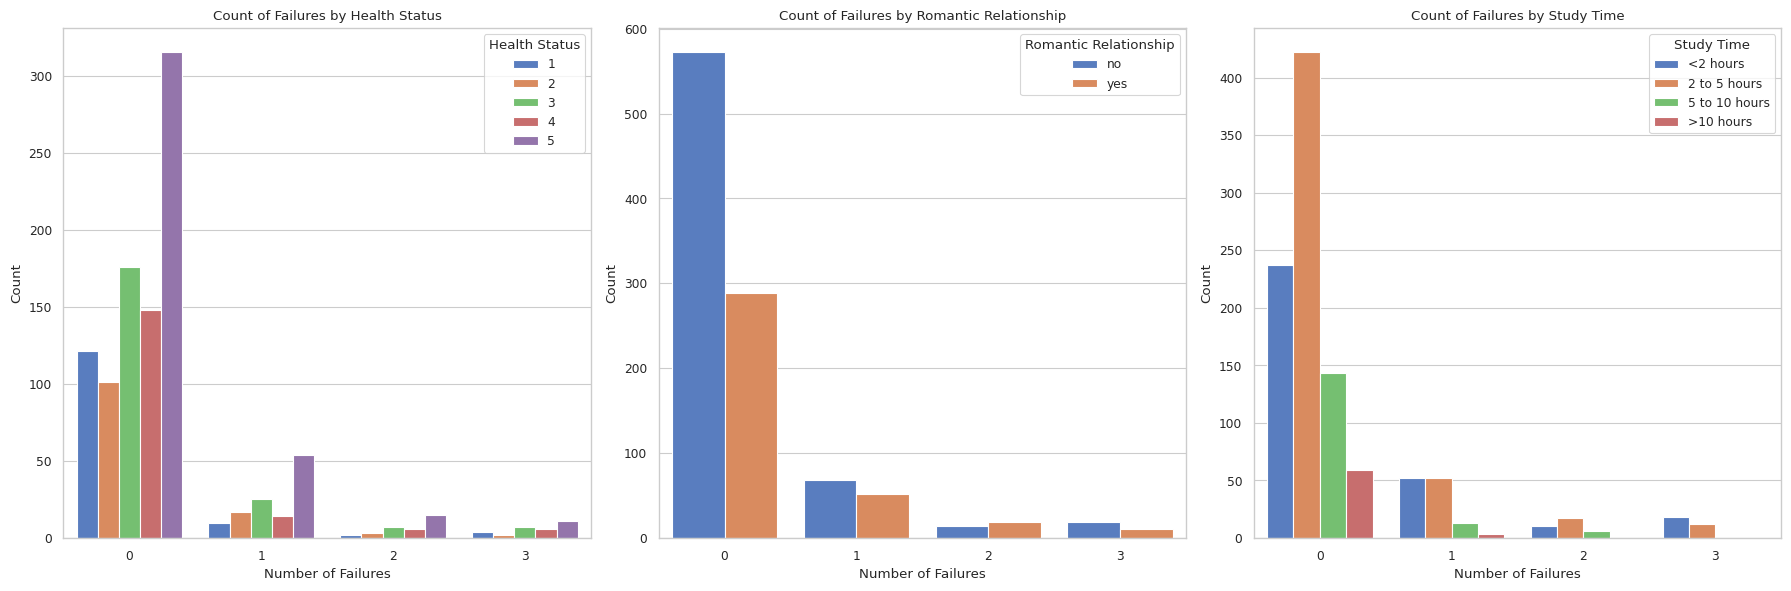

In [80]:
union_data_2_panda = union_data_2.toPandas()

# Define the desired order of study time categories
study_time_order = ["<2 hours", "2 to 5 hours", "5 to 10 hours", ">10 hours"]

# Set the figure size and style
plt.figure(figsize=(18, 6))

# Create a subplot for Health Status
plt.subplot(1, 3, 1)
sns.countplot(x='class_failures', data=union_data_2_panda, palette='muted', hue='health')
plt.title('Count of Failures by Health Status')
plt.xlabel('Number of Failures')
plt.ylabel('Count')
plt.legend(title='Health Status')

# Create a subplot for Romantic Relationship
plt.subplot(1, 3, 2)
sns.countplot(x='class_failures', data=union_data_2_panda, palette='muted', hue='romantic_relationship')
plt.title('Count of Failures by Romantic Relationship')
plt.xlabel('Number of Failures')
plt.ylabel('Count')
plt.legend(title='Romantic Relationship')

# Create a subplot for Study Time
plt.subplot(1, 3, 3)
sns.countplot(x='class_failures', data=union_data_2_panda, palette='muted', hue='study_time', hue_order=study_time_order)
plt.title('Count of Failures by Study Time')
plt.xlabel('Number of Failures')
plt.ylabel('Count')
plt.legend(title='Study Time')

# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()

**Are there any notable clusters or patterns in student performance based on a combination of multiple features like guardian type, reasons for school choice, and internet access at home?**

In [81]:
# Find unique values in data1
data1.select('guardian').distinct().show()
data1.select('school_choice_reason').distinct().show()
data1.select('internet_access').distinct().show()

+--------+
|guardian|
+--------+
|  father|
|  mother|
|   other|
+--------+

+--------------------+
|school_choice_reason|
+--------------------+
|          reputation|
|              course|
|               other|
|                home|
+--------------------+

+---------------+
|internet_access|
+---------------+
|             no|
|            yes|
+---------------+



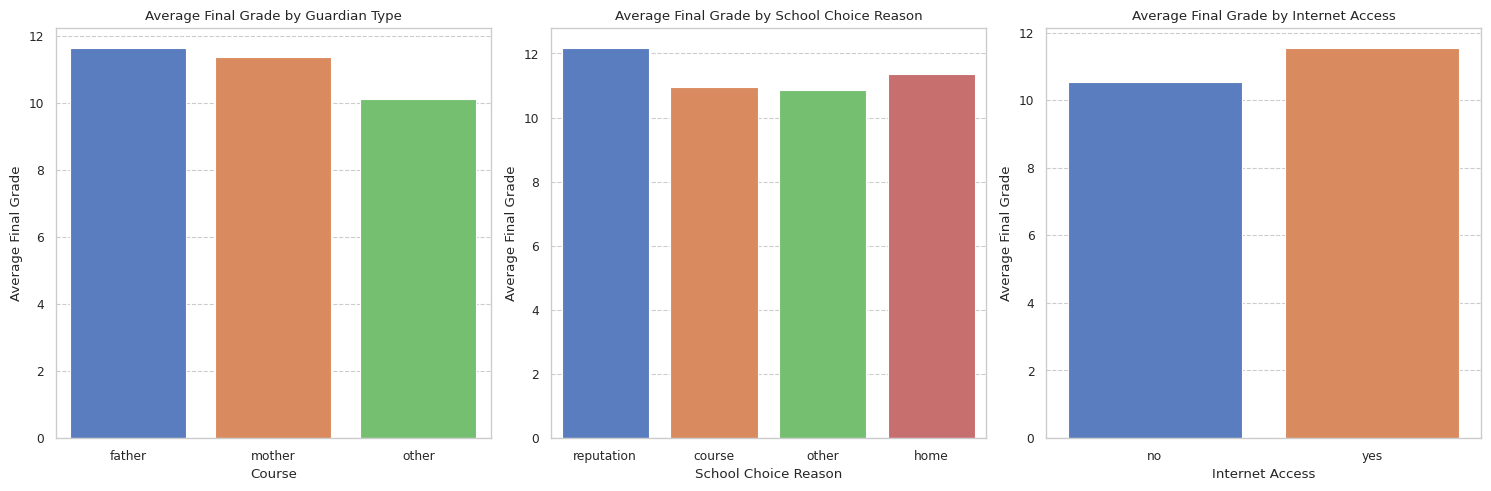

In [82]:
# Select relevant variables from data1 and data2
data1_selected = data1.select('guardian', 'school_choice_reason', 'internet_access', 'final_grade')
data2_selected = data2.select('guardian', 'school_choice_reason', 'internet_access', 'final_grade')

# Union the two DataFrames
union_data_1 = data1_selected.union(data2_selected)

# Group by guardian and compute the average final_grade
average_final_grade_by_guradian = union_data_1.groupBy('guardian').agg(avg('final_grade').alias('average_final_grade'))

# Group by school_choice_reason and compute the average final_grade
average_final_grade_by_reason = union_data_1.groupBy('school_choice_reason').agg(avg('final_grade').alias('average_final_grade'))

# Group by internet_access and compute the average final_grade
average_final_grade_by_internet_access = union_data_1.groupBy('internet_access').agg(avg('final_grade').alias('average_final_grade'))

# Convert Spark DataFrames to Pandas DataFrames for visualization
average_final_grade_by_guradian = average_final_grade_by_guradian.toPandas()
average_final_grade_by_reason = average_final_grade_by_reason.toPandas()
average_final_grade_by_internet_access = average_final_grade_by_internet_access.toPandas()

# Set the context to adjust the font scale of the legend
sns.set_context("paper", font_scale=1)

# Set the style to enable the grid and make it dotted
sns.set_style("whitegrid", {'grid.linestyle': '--'})

# Set the figure size
plt.figure(figsize=(15, 5))

# Bar Plot of Average Final Grade by Guardian Type
plt.subplot(1, 3, 1)
sns.barplot(data=average_final_grade_by_guradian, x='guardian', y='average_final_grade', hue='guardian', palette='muted', legend=False)
plt.xlabel('Course')
plt.ylabel('Average Final Grade')
plt.title('Average Final Grade by Guardian Type')

# Bar Plot of Average Final Grade by School Choice Reason
plt.subplot(1, 3, 2)
sns.barplot(data=average_final_grade_by_reason, x='school_choice_reason', y='average_final_grade', hue='school_choice_reason', palette='muted', legend=False)
plt.title('Average Final Grade by School Choice Reason')
plt.xlabel('School Choice Reason')
plt.ylabel('Average Final Grade')


# Bar Plot of Average Final Grade by Internet Access
plt.subplot(1, 3, 3)
sns.barplot(data=average_final_grade_by_internet_access, x='internet_access', y='average_final_grade', hue='internet_access', palette='muted', legend=False)
plt.title('Average Final Grade by Internet Access')
plt.xlabel('Internet Access')
plt.ylabel('Average Final Grade')


# Show the plots
plt.tight_layout()
plt.show()

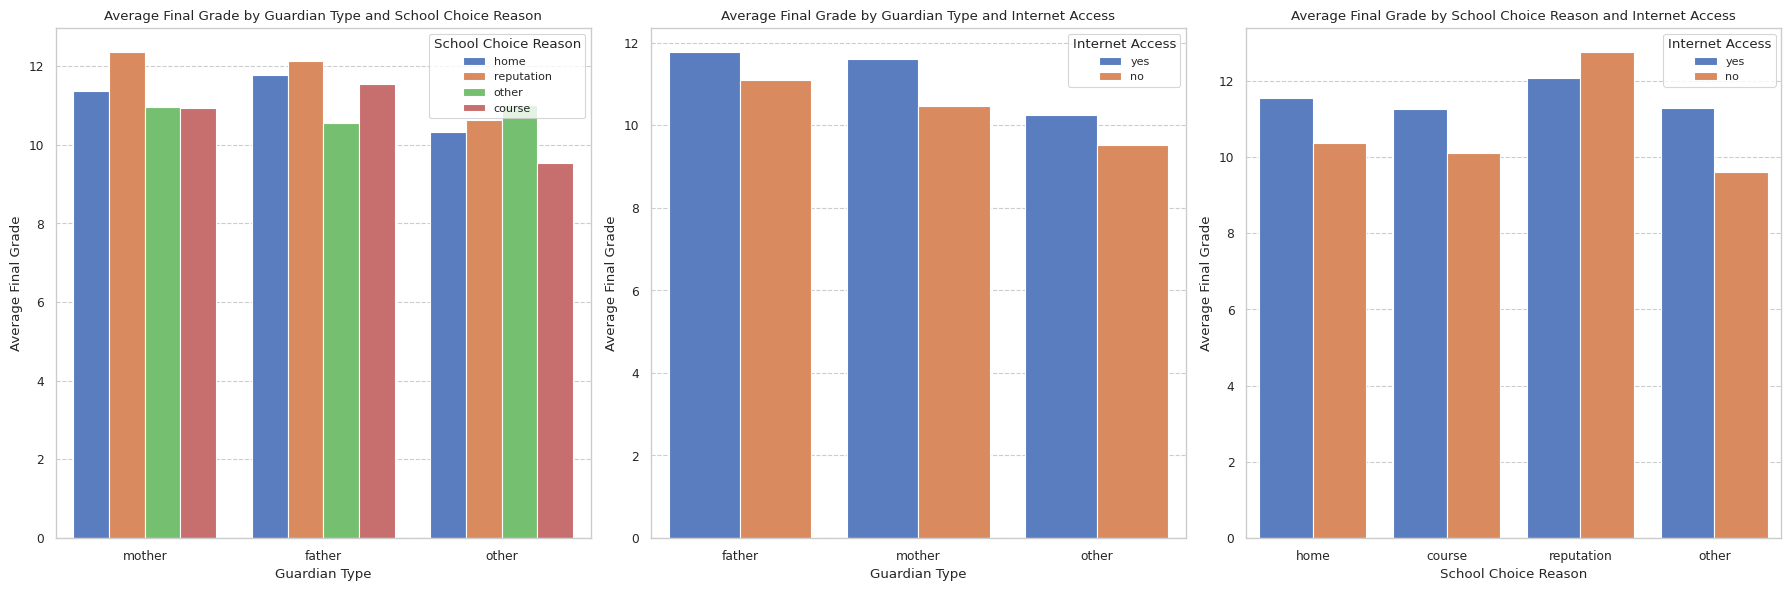

In [83]:
# Group by guardian and compute the average final_grade
group_1 = union_data_1.groupBy('guardian','school_choice_reason').agg(avg('final_grade').alias('average_final_grade'))

# Group by school_choice_reason and compute the average final_grade
group_2 = union_data_1.groupBy('guardian','internet_access').agg(avg('final_grade').alias('average_final_grade'))

# Group by internet_access and compute the average final_grade
group_3 = union_data_1.groupBy('school_choice_reason','internet_access').agg(avg('final_grade').alias('average_final_grade'))

# Convert Spark DataFrames to Pandas DataFrames for visualization
group_1 = group_1.toPandas()
group_2 = group_2.toPandas()
group_3 = group_3.toPandas()

# Set the figure size and style
plt.figure(figsize=(18, 6))

# Plot 1: Grouped Bar Plot of Average Final Grade by Guardian Type and School Choice Reason
plt.subplot(1, 3, 1)
sns.barplot(data=group_1, x='guardian', y='average_final_grade', hue='school_choice_reason', palette='muted')
plt.xlabel('Guardian Type')
plt.ylabel('Average Final Grade')
plt.title('Average Final Grade by Guardian Type and School Choice Reason')
plt.legend(title='School Choice Reason', loc='upper right', fontsize='small')

# Plot 2: Grouped Bar Plot of Average Final Grade by Guardian Type and Internet Access
plt.subplot(1, 3, 2)
sns.barplot(data=group_2, x='guardian', y='average_final_grade', hue='internet_access', palette='muted')
plt.xlabel('Guardian Type')
plt.ylabel('Average Final Grade')
plt.title('Average Final Grade by Guardian Type and Internet Access')
plt.legend(title='Internet Access', loc='upper right', fontsize='small')

# Plot 3: Grouped Bar Plot of Average Final Grade by School Choice Reason and Internet Access
plt.subplot(1, 3, 3)
sns.barplot(data=group_3, x='school_choice_reason', y='average_final_grade', hue='internet_access', palette='muted')
plt.xlabel('School Choice Reason')
plt.ylabel('Average Final Grade')
plt.title('Average Final Grade by School Choice Reason and Internet Access')
plt.legend(title='Internet Access', loc='upper right', fontsize='small')

# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()

**Is there a causal relationship between internet access, travel time, parental occupations, and students' study time?**

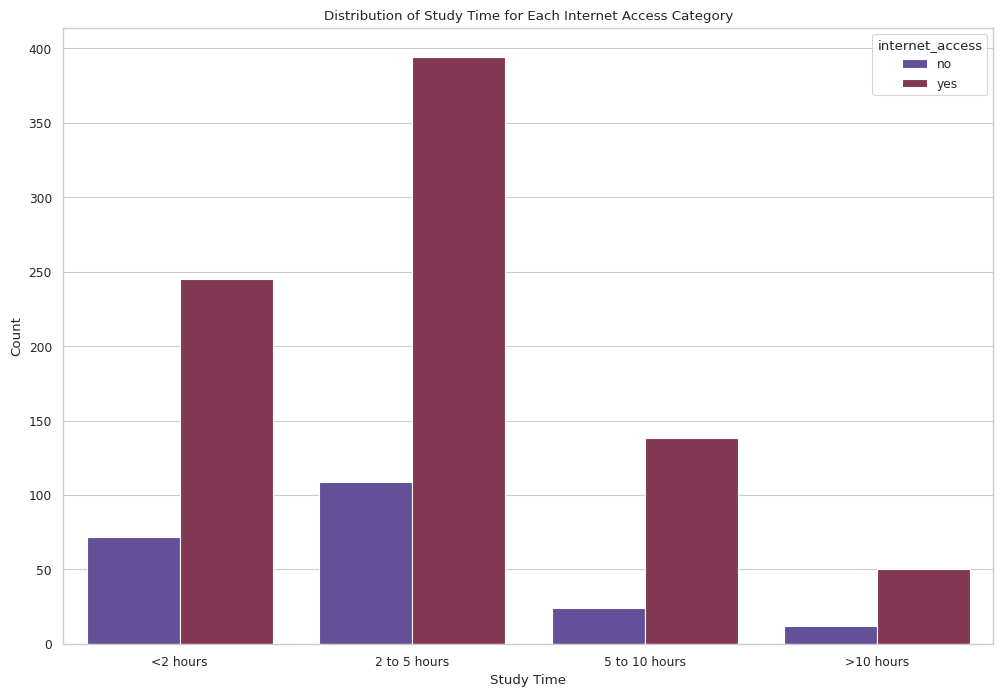

In [84]:
# Define the order of study time categories
study_time_order = ['<2 hours', '2 to 5 hours', '5 to 10 hours', '>10 hours']
# Study Time vs Internet Access
study_time_internet_result = combined_data.groupBy('study_time', 'internet_access').count().toPandas()
sns.set_palette("Paired")
sns.set_style("whitegrid")
plt.figure(figsize=(12, 8))
sns.barplot(x='study_time', y='count', hue='internet_access', data=study_time_internet_result, palette='twilight', order=study_time_order)
plt.title("Distribution of Study Time for Each Internet Access Category")
plt.xlabel("Study Time")
plt.ylabel("Count")
#plt.savefig('11-1.png')
plt.show()

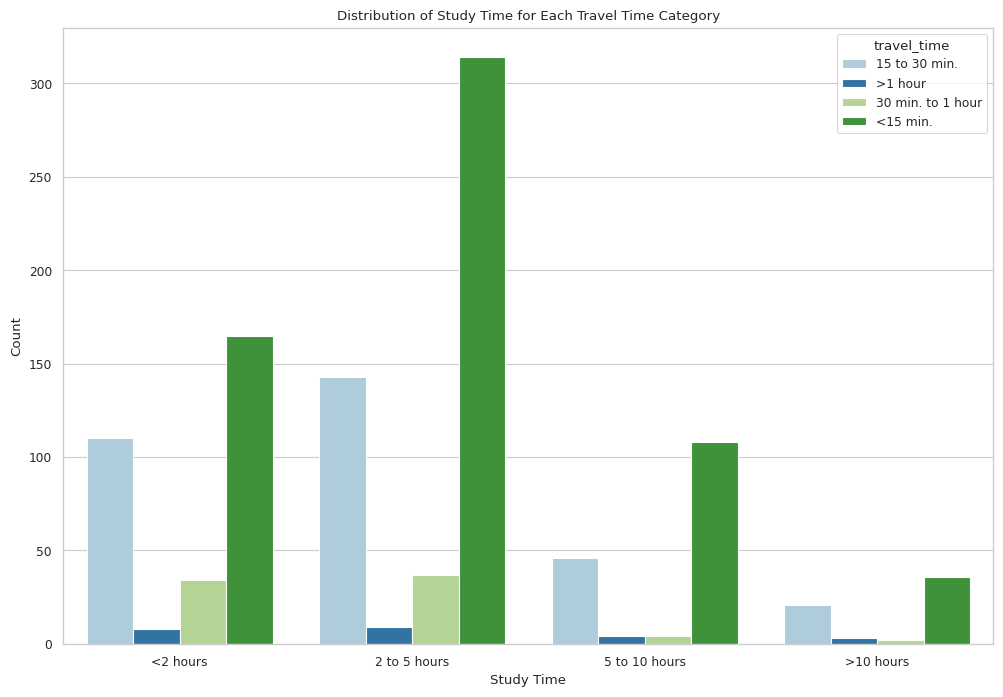

In [85]:
# Define the order of study time categories
study_time_order = ['<2 hours', '2 to 5 hours', '5 to 10 hours', '>10 hours']

# Travel Time vs Study Time
travel_time_study_result = combined_data.groupBy('travel_time', 'study_time').count().toPandas()
sns.set_style("whitegrid")
plt.figure(figsize=(12, 8))
sns.barplot(x='study_time', y='count', hue='travel_time', data=travel_time_study_result, palette='Paired', order=study_time_order)
plt.title("Distribution of Study Time for Each Travel Time Category")
plt.xlabel("Study Time")
plt.ylabel("Count")
#plt.savefig('11-2.png')
plt.show()

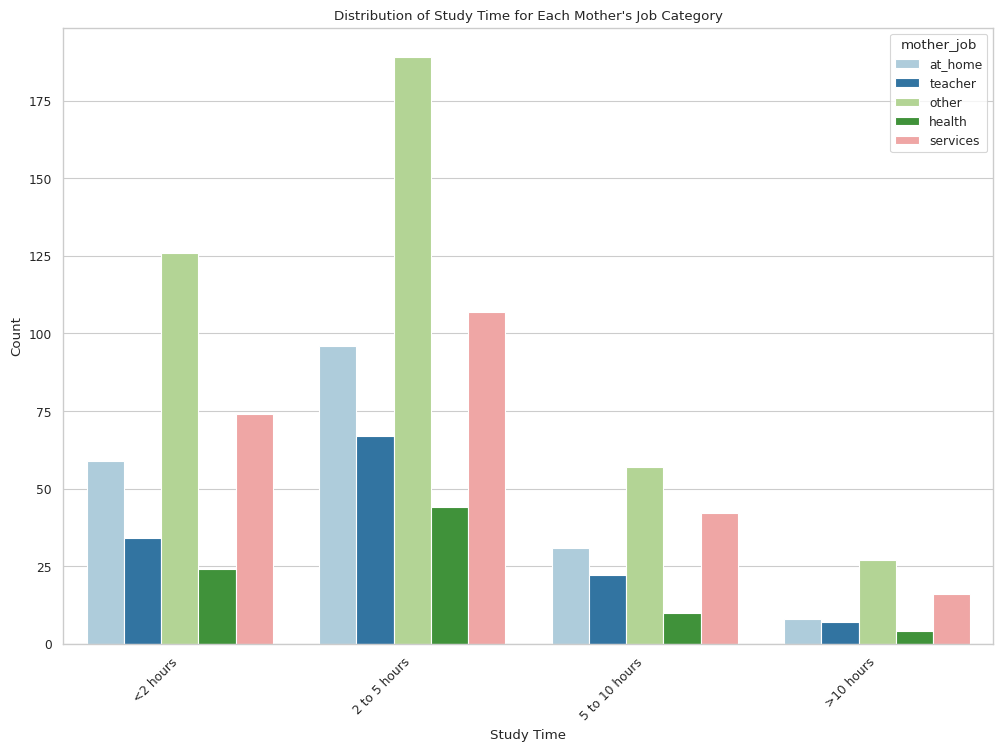

In [86]:
# Define the order of study time categories
study_time_order = ['<2 hours', '2 to 5 hours', '5 to 10 hours', '>10 hours']

# Mother's Job vs Study Time
mother_job_study_result = combined_data.groupBy('mother_job', 'study_time').count().toPandas()
sns.set_palette("twilight")
sns.set_style("whitegrid")
plt.figure(figsize=(12, 8))
sns.barplot(x='study_time', y='count', hue='mother_job', data=mother_job_study_result, palette='Paired', order=study_time_order)
plt.title("Distribution of Study Time for Each Mother's Job Category")
plt.xlabel("Study Time")
plt.ylabel("Count")
plt.xticks(rotation=45, ha="right")
#plt.savefig('11-3.png')
plt.show()

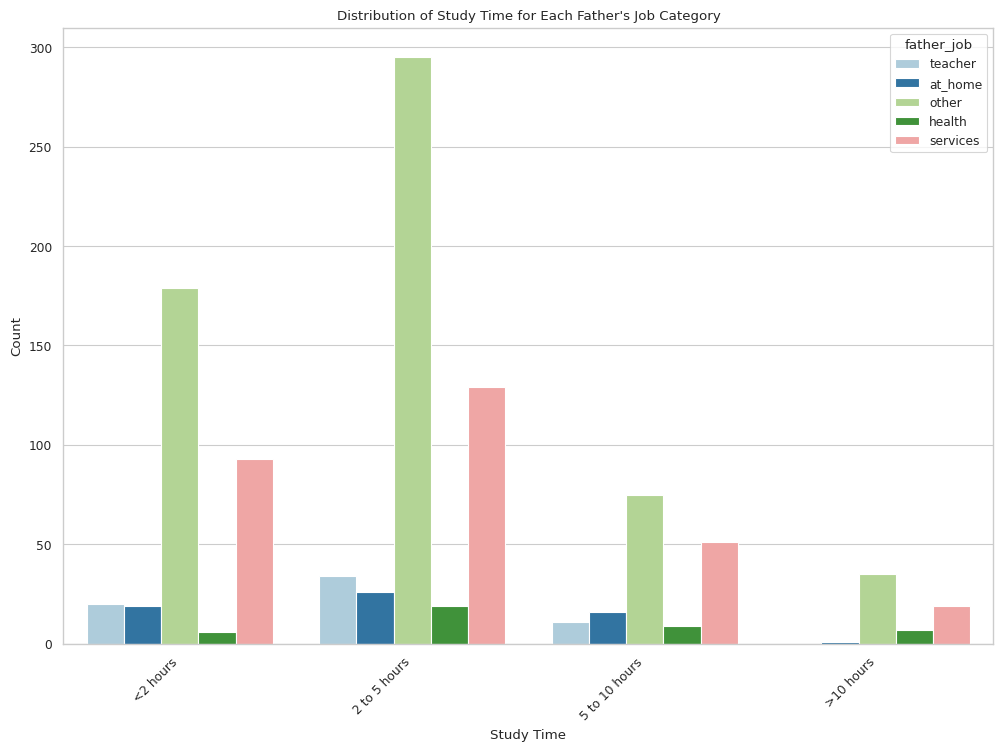

In [87]:
# Father's Job vs Study Time
father_job_study_result = combined_data.groupBy('father_job', 'study_time').count().toPandas()

plt.figure(figsize=(12, 8))
sns.barplot(x='study_time', y='count', hue='father_job', data=father_job_study_result, palette='Paired', order=study_time_order)
plt.title("Distribution of Study Time for Each Father's Job Category")
plt.xlabel("Study Time")
plt.ylabel("Count")
plt.xticks(rotation=45, ha="right")
#plt.savefig('11-4.png')
plt.show()

**What study time intervals should be prescribed for optimal academic performance based on varying family sizes and guardian types?**

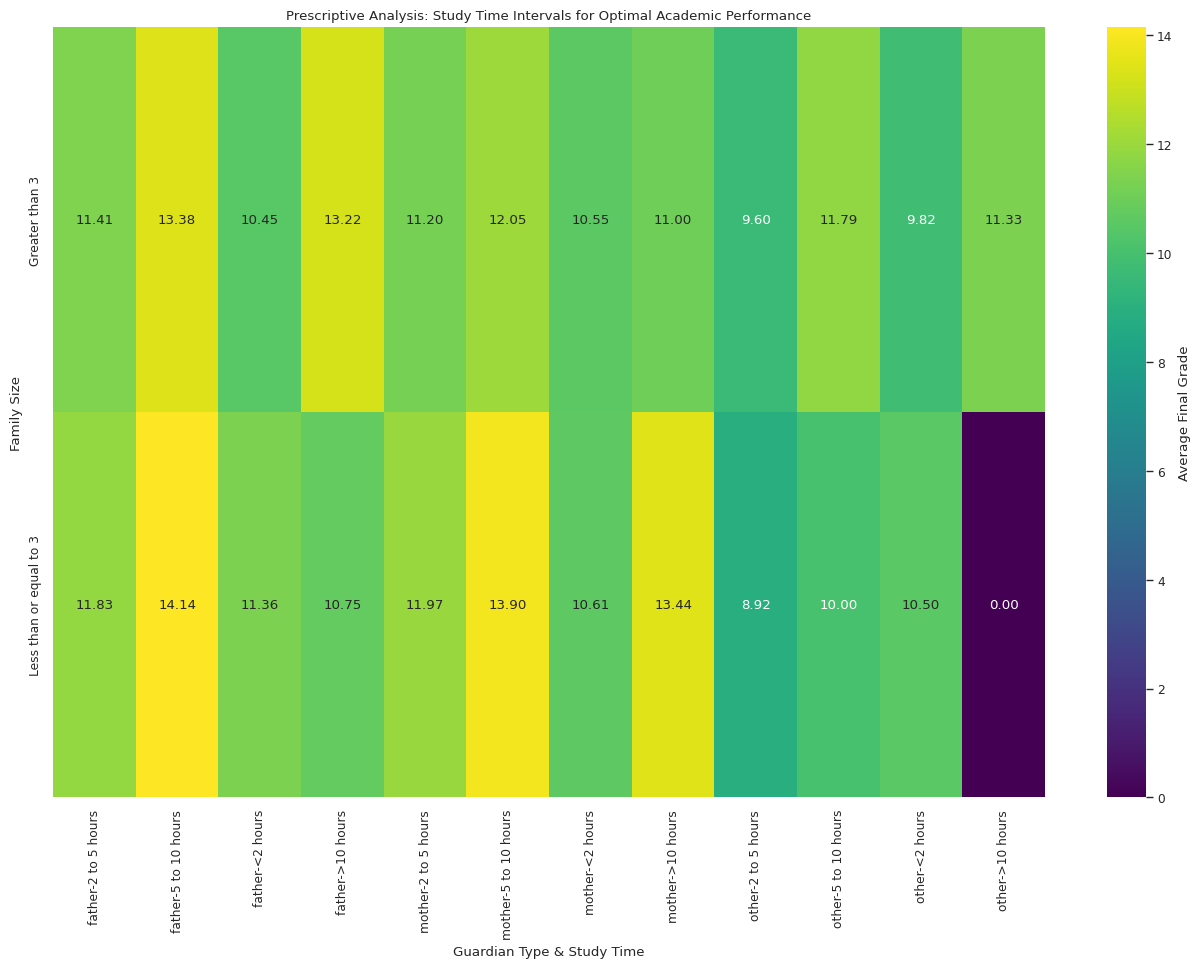

In [88]:
# Define the order of study time categories
study_time_order = ['<2 hours', '2 to 5 hours', '5 to 10 hours', '>10 hours']

# Set the Seaborn color palette
sns.set_palette("viridis")

# Study Time vs Family Size vs Guardian Type
prescriptive_result = combined_data.groupBy('study_time', 'family_size', 'guardian').agg({'final_grade': 'mean'}).toPandas()

plt.figure(figsize=(16, 10))
heatmap_data = prescriptive_result.pivot_table(index='family_size', columns=['guardian', 'study_time'], values='avg(final_grade)', fill_value=0)
sns.heatmap(heatmap_data, cmap='viridis', annot=True, fmt='.2f', cbar_kws={'label': 'Average Final Grade'})
plt.title("Prescriptive Analysis: Study Time Intervals for Optimal Academic Performance")
plt.xlabel("Guardian Type & Study Time")
plt.ylabel("Family Size")
#plt.savefig('12-2.png')
plt.show()